<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML%20SOM%20DBA%20ECG%20timeseries%20clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tslearn minisom dtw-python --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.1/789.1 kB 19.7 MB/s eta 0:00:00


In [2]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.utils import to_time_series_dataset
from minisom import MiniSom
import random

https://www.kaggle.com/code/denisandrikov/introduction-to-time-series-clustering/notebook

https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/small_MITBIH_ECG.csv

In [25]:
df_mitbih.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,...,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,0.891510,0.754685,0.415382,0.213509,0.195808,0.206872,0.203271,0.202084,0.201196,0.200381,...,0.003827,0.003886,0.003647,0.003695,0.003801,0.003855,0.003422,0.003332,0.003446,0.464088
std,0.243736,0.227322,0.224198,0.198916,0.166357,0.161494,0.169398,0.171040,0.169024,0.166599,...,0.034224,0.034338,0.033008,0.033488,0.034347,0.035295,0.034513,0.037210,0.039298,1.122482
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.927630,0.670962,0.239980,0.050533,0.082248,0.089258,0.074146,0.067961,0.065711,0.070934,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.988372,0.826495,0.424947,0.163478,0.151213,0.160448,0.145522,0.150485,0.163121,0.158598,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.912487,0.574154,0.336942,0.254921,0.286208,0.296937,0.293148,0.293364,0.287588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.973485,0.914184,0.956204,1.000000,1.000000,0.959161,0.932671,...,0.521886,0.481481,0.461279,0.484848,0.468013,0.498221,0.686833,0.903915,1.000000,4.000000


In [30]:
#датасет большой, поэтому сформируем случайным образом тренировочный датасет
import random

file_path = '/content/small_MITBIH_ECG.csv'

n = 1000 #number of records in file
s = 900 #desired sample size
skip = sorted(random.sample(range(n),n-s))

df_mitbih = pd.read_csv(file_path, sep=',', skiprows=skip)

# датасет размечен на 5 классов
# в исходном датасете столбец №187 содержит номер класса
df_mitbih.rename(columns={187: 'class'}, inplace=True)



# добавим текстовое описание к размеченным классам
id_to_label = {
    0: "Normal",     #0: "Нормальный"
    1: "Artial Premature", # "Преждевременное сокращение сердца (экстрасистолия)"
    2: "Premature ventricular contraction", # "Преждевременное сокращение желудочков"
    3: "Fusion of ventricular and normal",  # "Cлияние желудочкового и нормального сердечного ритма"
    4: "Fusion of paced and normal" #"Cлияние стимулированного и нормального ритма"
}
df_mitbih['class'] = df_mitbih.iloc[:, -1].map(id_to_label)


print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Columns: 189 entries, 0 to class
dtypes: float64(188), object(1)
memory usage: 1.8+ MB
None


In [31]:
df_mitbih.head(3)

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,class
0,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,0.969697,1.000000,0.523232,0.147475,0.060606,0.014141,0.004040,0.006061,0.056566,0.206061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
2,0.964413,0.658363,0.113879,0.074733,0.124555,0.096085,0.071174,0.067616,0.060498,0.049822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


In [32]:
print("Data loaded:")
print(df_mitbih.head())
print(df_mitbih.shape)

Data loaded:
          0         1         2         3         4         5         6  \
0  0.908425  0.783883  0.531136  0.362637  0.366300  0.344322  0.333333   
1  0.969697  1.000000  0.523232  0.147475  0.060606  0.014141  0.004040   
2  0.964413  0.658363  0.113879  0.074733  0.124555  0.096085  0.071174   
3  0.863057  0.853503  0.382166  0.015924  0.000000  0.015924  0.108280   
4  1.000000  0.987500  0.687500  0.178125  0.071875  0.162500  0.225000   

          7         8         9  ...  179  180  181  182  183  184  185  186  \
0  0.307692  0.296703  0.300366  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.006061  0.056566  0.206061  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.067616  0.060498  0.049822  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.085987  0.073248  0.136943  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.225000  0.187500  0.150000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   187   class  
0  0.0  Normal  
1  0.0  Normal  
2  0

In [34]:
# Separate features (time series) and true labels
X_raw = df_mitbih.iloc[:, :187]  # First 187 columns are the time series
y_true = df_mitbih.iloc[:, 187]  # Column 187 is the class label

# Optional: Add label descriptions if needed later
id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
# y_true_labels = y_true.map(id_to_label) # Map numeric labels to text if desired

print("\nTrue Label Distribution:")
print(y_true.value_counts().sort_index())



True Label Distribution:
187
0.0    1043
1.0      44
2.0      82
3.0       8
4.0      89
Name: count, dtype: int64


In [35]:
# --- Normalize Time Series ---
# Standardize each time series individually (zero mean, unit variance)
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_raw.T).T  # Transpose to scale along time axis
X_scaled_tslearn = to_time_series_dataset(X_scaled_array) # Convert for tslearn compatibility

print("\nData normalized.")
print(f"Raw shape: {X_raw.shape}")
print(f"Scaled array shape: {X_scaled_array.shape}")
print(f"Scaled tslearn dataset shape: {X_scaled_tslearn.shape}")


Data normalized.
Raw shape: (1266, 187)
Scaled array shape: (1266, 187)
Scaled tslearn dataset shape: (1266, 187, 1)


#  Unsupervised Clustering


--- Running Standard K-Means (Baseline) ---
Number of clusters (K): 5


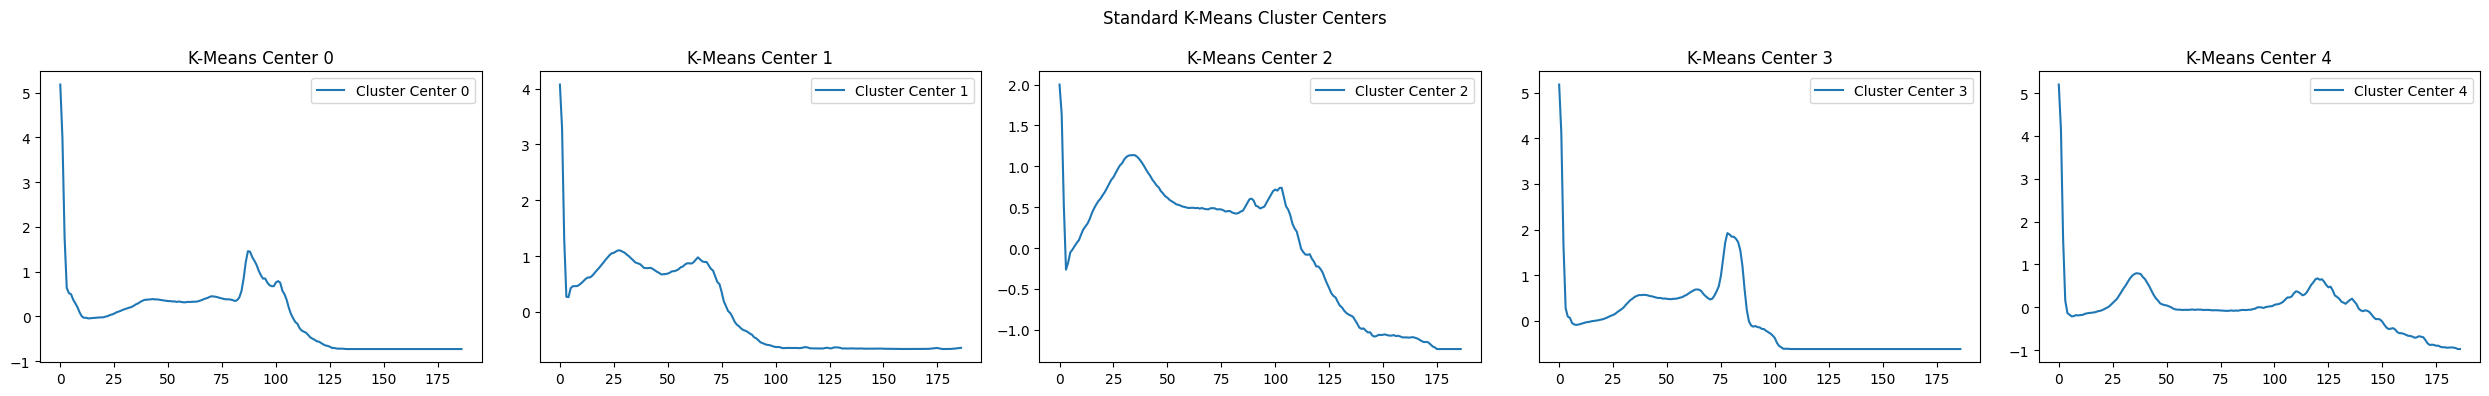


Adjusted Rand Index (K-Means vs True Labels): 0.0015


In [36]:
# --- 1. Baseline: Standard K-Means on Normalized Data ---
print("\n--- Running Standard K-Means (Baseline) ---")
n_clusters = len(y_true.unique()) # Use number of unique classes as K
print(f"Number of clusters (K): {n_clusters}")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels_kmeans = kmeans.fit_predict(X_scaled_array)

# Plot K-Means Centers
fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(5*n_clusters, 4))
if n_clusters == 1:
    axes = [axes] # Make iterable if only one subplot
for i, ax in enumerate(axes):
    center = kmeans.cluster_centers_[i]
    ax.plot(center, label=f'Cluster Center {i}')
    ax.set_title(f'K-Means Center {i}')
    ax.legend()
plt.suptitle('Standard K-Means Cluster Centers')
plt.tight_layout()
plt.show()

# Evaluate against true labels (if available)
ari_kmeans = adjusted_rand_score(y_true, cluster_labels_kmeans)
print(f"\nAdjusted Rand Index (K-Means vs True Labels): {ari_kmeans:.4f}")

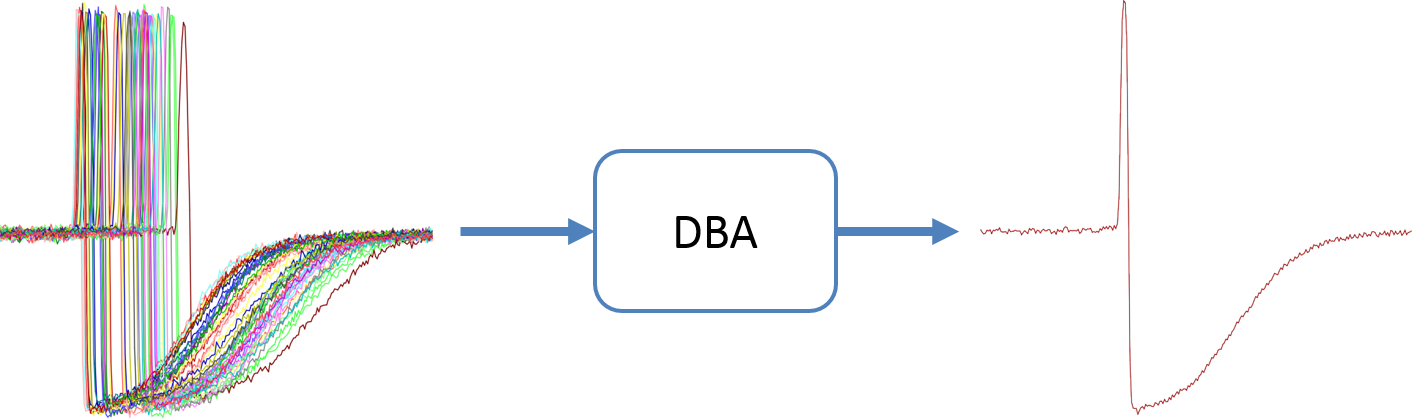

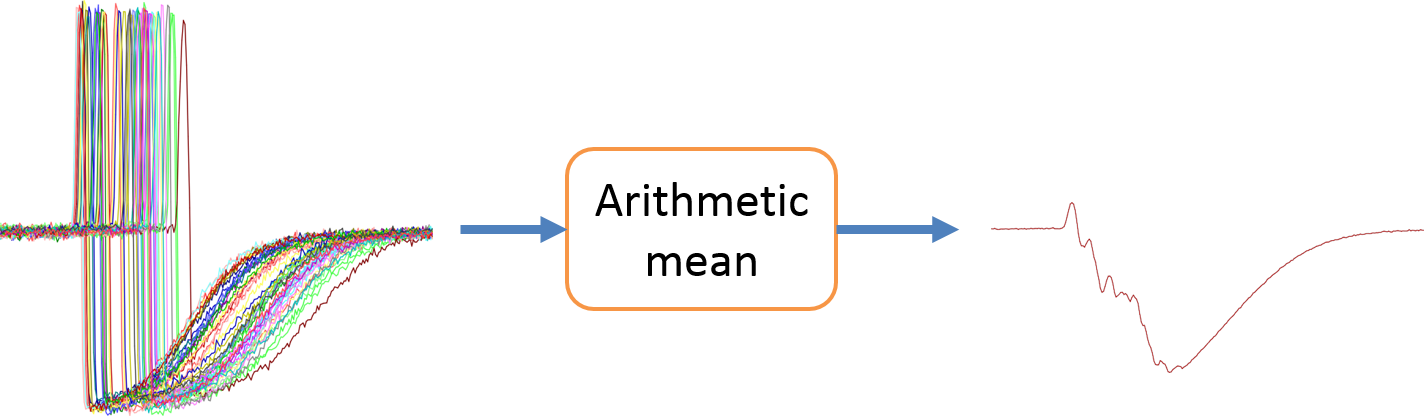


Number of clusters (K) set to number of unique labels: 5

--- Running DBA (Dynamic Time Warping Barycenter Averaging) ---
Initial DBA centroids shape: (5, 187)
Starting DBA iterations...
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5

DBA iterations completed.
Final DBA centroids shape: (5, 187)


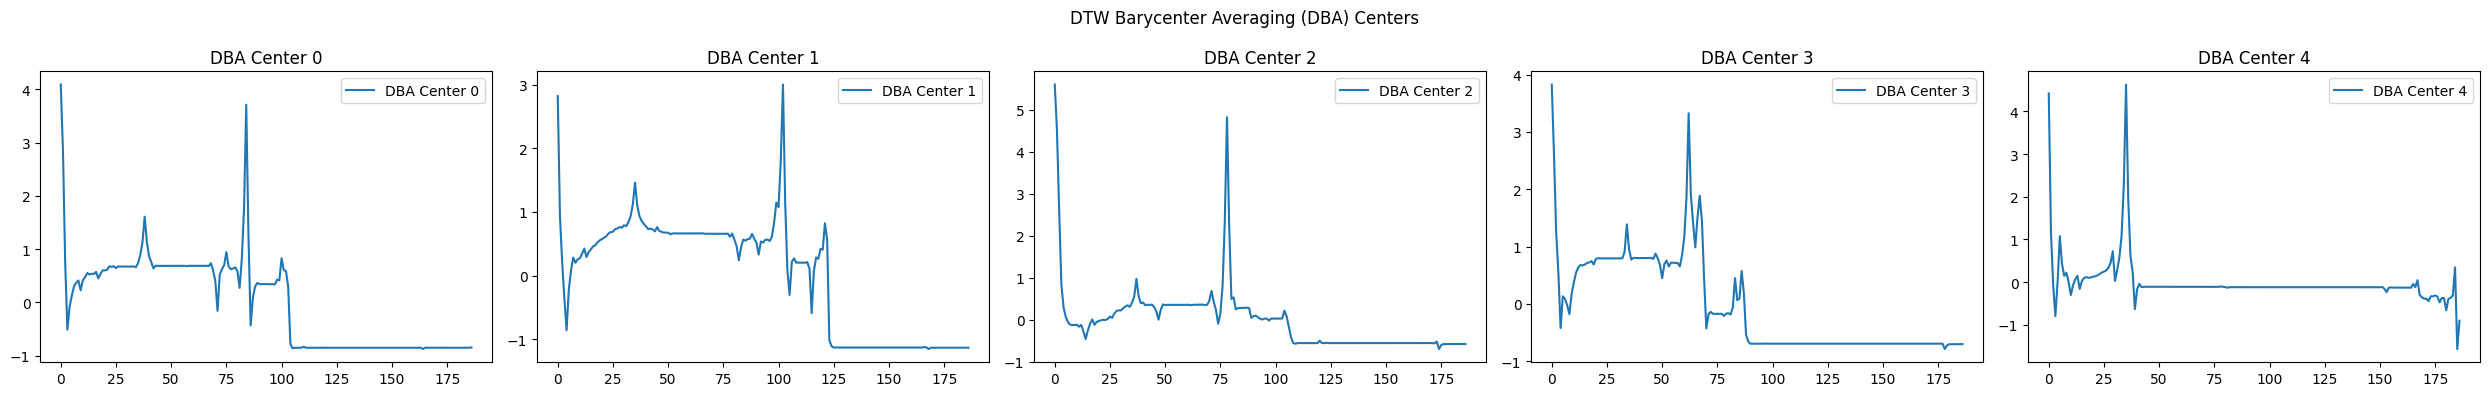


Adjusted Rand Index (DBA Clusters vs True Labels): 0.0171

--- Running Standard K-Means (Baseline) ---


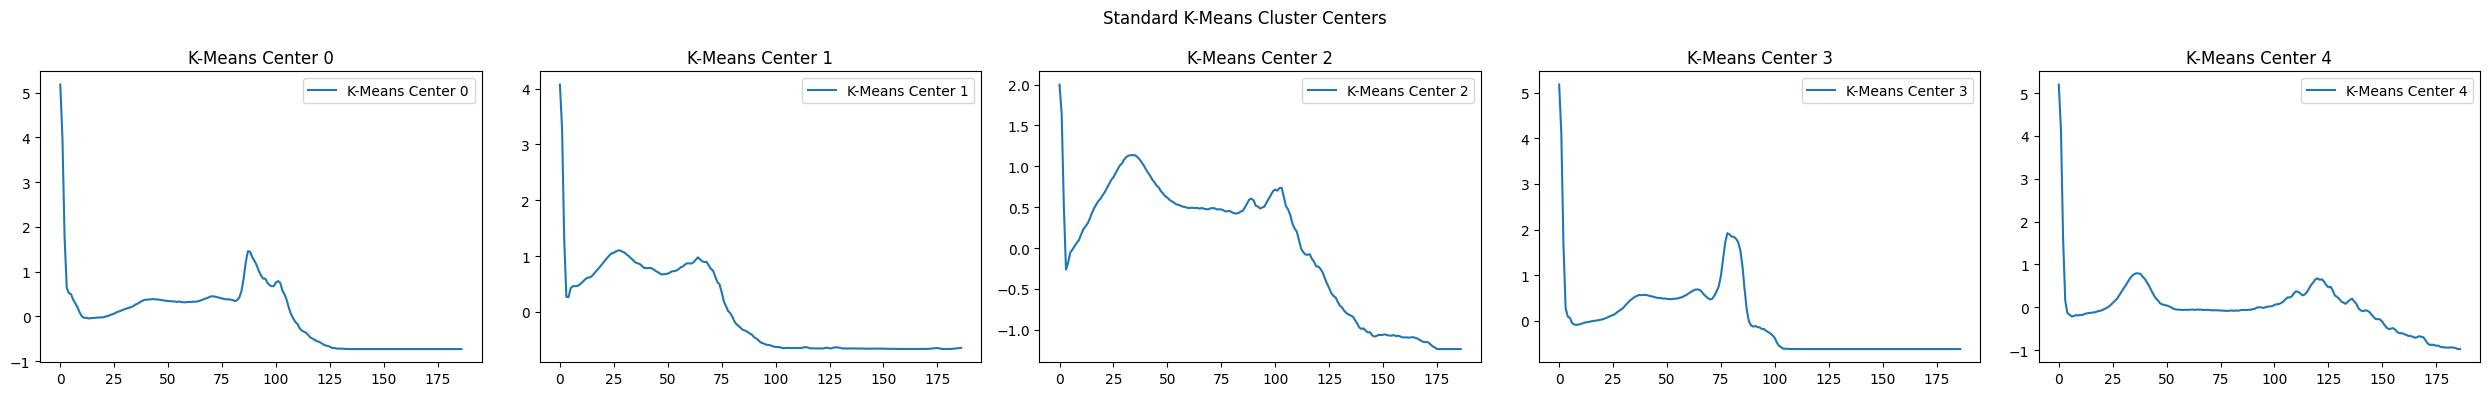


Adjusted Rand Index (K-Means Clusters vs True Labels): 0.0015


In [40]:
# --- Determine Number of Clusters ---
# Use the number of unique classes in the data as the number of clusters (K)
n_clusters = len(np.unique(y_true))
print(f"\nNumber of clusters (K) set to number of unique labels: {n_clusters}")

# --- Unsupervised Clustering ---

# --- 1. DBA within K-Means-like Algorithm ---
print("\n--- Running DBA (Dynamic Time Warping Barycenter Averaging) ---")

# Parameters for DBA
max_iter_dba = 5 # Number of DBA refinement iterations. Increase for better convergence (slower).
verbose_dba = True # Print progress

# Function to initialize centroids (simple approach)
def initialize_centroids(X, n_clusters):
    """Initialize centroids using K-Means++ logic on flattened data."""
    kmeans_init = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, random_state=42)
    _ = kmeans_init.fit(X) # Fit on flattened data for initialization
    initial_centroids = kmeans_init.cluster_centers_
    # Reshape back to time series format
    return initial_centroids.reshape(n_clusters, -1) # Shape: (n_clusters, n_timestamps)

# Initialize centroids using standard K-Means approach on normalized data
dba_centroids = initialize_centroids(X_scaled_array, n_clusters)
print(f"Initial DBA centroids shape: {dba_centroids.shape}")

print("Starting DBA iterations...")
for it in range(max_iter_dba):
    if verbose_dba:
        print(f"Iteration {it + 1}/{max_iter_dba}")

    # --- Assignment Step ---
    # Assign each series to the closest centroid based on DTW distance
    distances_dba = np.zeros((X_scaled_array.shape[0], n_clusters))
    for i, series in enumerate(X_scaled_array):
        for j, centroid in enumerate(dba_centroids):
            # Calculate DTW distance using dtw-python library correctly
            # dtw returns an object, we need the distance attribute
            alignment = dtw(series, centroid, keep_internals=False)
            dist = alignment.distance
            distances_dba[i, j] = dist

    cluster_labels_dba = np.argmin(distances_dba, axis=1)

    # --- Update Step (DBA) ---
    # Update centroids using DBA on the newly formed clusters
    new_centroids = []
    for k in range(n_clusters):
        cluster_series_indices = np.where(cluster_labels_dba == k)[0]
        if len(cluster_series_indices) > 0:
            cluster_data_for_dba = X_scaled_array[cluster_series_indices]
            # Ensure data is in the correct 3D format for tslearn DBA: (n_series, n_timestamps, n_dims)
            cluster_data_for_dba_reshaped = cluster_data_for_dba[:, :, np.newaxis]

            # Perform DBA using tslearn's optimized function
            # It takes the set of series and returns the barycenter (average) series
            dba_avg_series = dtw_barycenter_averaging(
                cluster_data_for_dba_reshaped,
                # barycenter_size=X_scaled_array.shape[1], # Usually inferred
                max_iter=10, # Max iterations for internal DBA convergence
                # tol=1e-5, # Tolerance for internal DBA convergence
                verbose=False # Set to True for detailed DBA logs per cluster
            )
            # Squeeze to remove the extra dimension added for tslearn: (n_timestamps, 1) -> (n_timestamps,)
            new_centroids.append(dba_avg_series.squeeze())
        else:
            # Handle empty cluster (rare but possible)
            print(f"Warning: Cluster {k} is empty at iteration {it+1}. Retaining previous centroid.")
            new_centroids.append(dba_centroids[k])

    # Update the centroids for the next iteration
    dba_centroids = np.array(new_centroids)

# --- Final Assignment after DBA iterations ---
# Recalculate distances to final centroids for final cluster labels
final_distances_dba = np.zeros((X_scaled_array.shape[0], n_clusters))
for i, series in enumerate(X_scaled_array):
    for j, centroid in enumerate(dba_centroids):
        alignment = dtw(series, centroid, keep_internals=False)
        dist = alignment.distance
        final_distances_dba[i, j] = dist
cluster_labels_dba_final = np.argmin(final_distances_dba, axis=1)

print("\nDBA iterations completed.")
print(f"Final DBA centroids shape: {dba_centroids.shape}")

# --- Plot DBA Centers ---
fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(5*n_clusters, 4))
if n_clusters == 1:
    axes = [axes] # Make iterable if only one subplot
for i, ax in enumerate(axes):
    center = dba_centroids[i]
    ax.plot(center, label=f'DBA Center {i}')
    ax.set_title(f'DBA Center {i}')
    ax.legend()
plt.suptitle('DTW Barycenter Averaging (DBA) Centers')
plt.tight_layout()
plt.show()

# --- Evaluate DBA Clustering Performance ---
# Compare final DBA-derived cluster labels with true labels using Adjusted Rand Index (ARI)
# ARI score ranges from -1 to 1. Score of 1 indicates perfect agreement, score around 0 is random.
ari_dba = adjusted_rand_score(y_true, cluster_labels_dba_final)
print(f"\nAdjusted Rand Index (DBA Clusters vs True Labels): {ari_dba:.4f}")

# --- 2. Standard K-Means (Baseline for Comparison) ---
print("\n--- Running Standard K-Means (Baseline) ---")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels_kmeans = kmeans.fit_predict(X_scaled_array)

# Plot K-Means Centers
fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(5*n_clusters, 4))
if n_clusters == 1:
    axes = [axes]
for i, ax in enumerate(axes):
    center = kmeans.cluster_centers_[i]
    ax.plot(center, label=f'K-Means Center {i}')
    ax.set_title(f'K-Means Center {i}')
    ax.legend()
plt.suptitle('Standard K-Means Cluster Centers')
plt.tight_layout()
plt.show()

# Evaluate K-Means
ari_kmeans = adjusted_rand_score(y_true, cluster_labels_kmeans)
print(f"\nAdjusted Rand Index (K-Means Clusters vs True Labels): {ari_kmeans:.4f}")


--- Running Self-Organizing Map (SOM) ---
Training SOM...
SOM training complete.


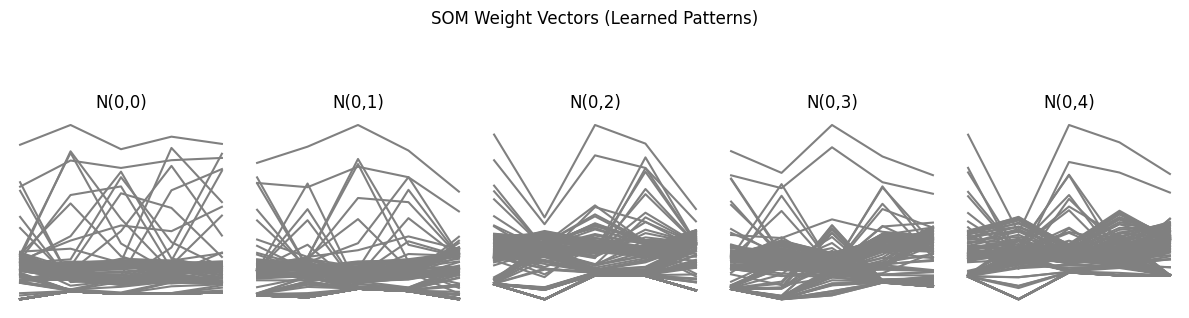

In [45]:

# --- 3. Self-Organizing Map (SOM) ---
print("\n--- Running Self-Organizing Map (SOM) ---")
# Define SOM grid dimensions (can be adjusted)
som_x, som_y = 5, 5 # Creates a 10x10 map
som_neurons = som_x * som_y

# Initialize SOM
som = MiniSom(x=som_x, y=som_y, input_len=X_scaled_array.shape[1], sigma=1.0, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=42)

# Initialize weights (random or using PCA could be better, but random is simple)
som.random_weights_init(X_scaled_array)
print("Training SOM...")
# Train SOM
som.train_random(X_scaled_array, num_iteration=1000) # Adjust iterations as needed
print("SOM training complete.")

# Get Best Matching Units (BMUs) for each sample
bmus = np.array([som.winner(x) for x in X_scaled_array])
# Map BMU coordinates to a single index for potential clustering analysis
bmu_indices = np.ravel_multi_index(bmus.T, (som_x, som_y))


# --- Enhanced SOM Visualization ---
# Create a mapping from BMU coordinates to the list of series assigned to that neuron
win_map = som.win_map(X_scaled_array, return_indices=False)


# Plot SOM Weight Vectors (representing learned patterns)
plt.figure(figsize=(12, 12))
for i, weights in enumerate(som.get_weights()):
    plt.subplot(som_x, som_y, i + 1)
    # Reshape weight vector back to time series shape if necessary,
    # but here they are already flat representations of the series.
    plt.plot(weights, color='gray')
    plt.title(f"N({i//som_y},{i % som_y})") # Show neuron coordinates
    plt.axis('off') # Turn off axis for cleaner look
plt.suptitle('SOM Weight Vectors (Learned Patterns)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to fit suptitle
plt.show()




Plotting SOM clusters...


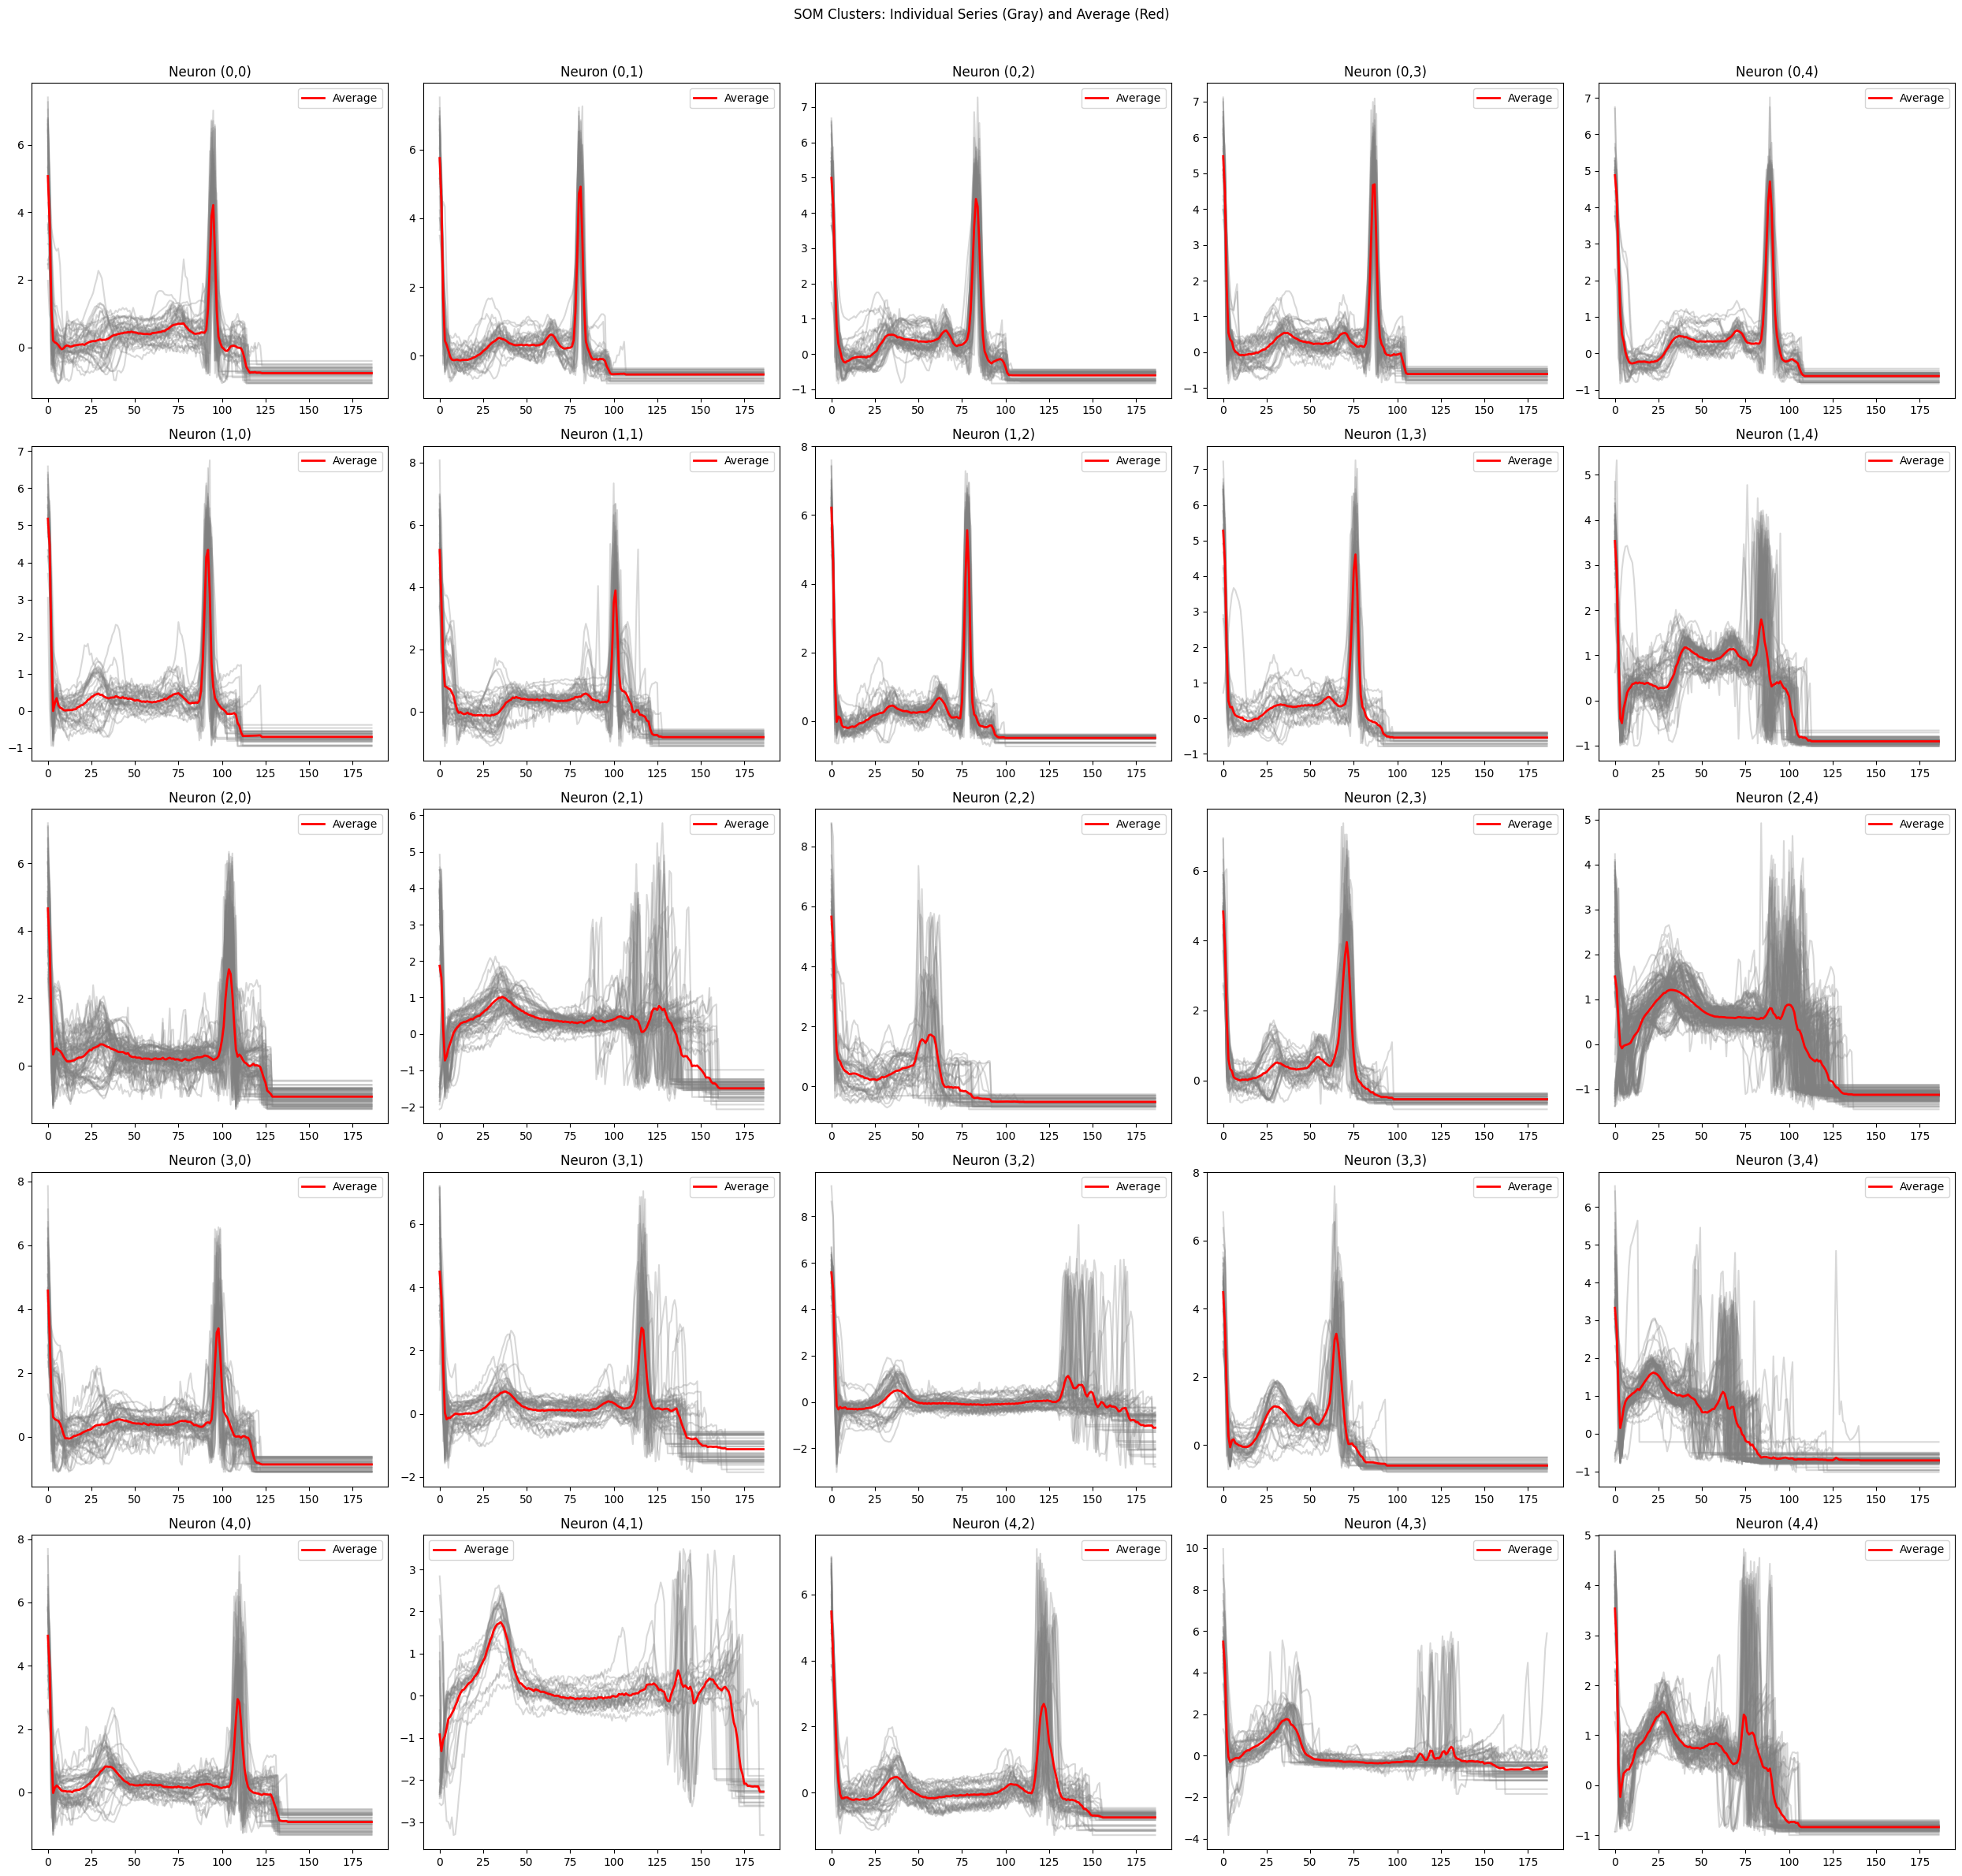

SOM cluster plot displayed.

Adjusted Rand Index (SOM Neurons vs True Labels): -0.0034


In [46]:
# Little handy function to plot series for SOM
def plot_som_series_averaged_center(som_x, som_y, win_map, data_shape):
    """
    Plots the SOM clusters.
    Each subplot corresponds to a neuron.
    Individual series in the cluster are plotted in light gray and transparent.
    The average (barycenter) of the cluster is plotted in red.
    """
    fig, axs = plt.subplots(som_x, som_y, figsize=(25, 25))
    if som_x == 1 and som_y == 1:
        axs = np.array([axs])
    elif som_x == 1 or som_y == 1:
        axs = axs.reshape(-1) # Ensure axs is always 2D for consistent indexing
    axs = axs.reshape(som_x, som_y) # Ensure axs is always 2D for consistent indexing

    fig.suptitle('SOM Clusters: Individual Series (Gray) and Average (Red)')
    for x in range(som_x):
        for y in range(som_y):
            cluster_key = (x, y)
            axs[x, y].set_title(f"Neuron ({x},{y})")
            if cluster_key in win_map and len(win_map[cluster_key]) > 0:
                cluster_series = np.array(win_map[cluster_key])
                # Handle potential issue with single series in cluster for vstack
                if cluster_series.ndim == 1:
                     cluster_series = cluster_series.reshape(1, -1)

                # Plot individual series in gray, semi-transparent
                for series in cluster_series:
                    axs[x, y].plot(series, c="gray", alpha=0.3)

                # Calculate and plot the average series for the cluster in red
                # Use nanmean to handle potential issues, though unlikely with MiniSom win_map
                avg_series = np.nanmean(cluster_series, axis=0)
                axs[x, y].plot(avg_series, c="red", linewidth=2, label="Average")
                axs[x, y].legend()
            else:
                 axs[x, y].text(0.5, 0.5, 'Empty', horizontalalignment='center',
                               verticalalignment='center', transform=axs[x, y].transAxes)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to fit suptitle
    plt.show()


# Call the plotting function
print("Plotting SOM clusters...")
plot_som_series_averaged_center(som_x, som_y, win_map, X_scaled_array.shape)
print("SOM cluster plot displayed.")


# Evaluate SOM clustering (using BMU index as cluster label)
ari_som = adjusted_rand_score(y_true, bmu_indices)
print(f"\nAdjusted Rand Index (SOM Neurons vs True Labels): {ari_som:.4f}")